In [2]:
import cv2
import numpy as np
import joblib
import tensorflow as tf
import time

IMG_SIZE = 48
DICT_SIZE = 2048
SAVE_DIR = "model_deep/"   # hoặc đường dẫn bạn lưu .joblib/.h5


In [3]:
# Load các model đã train:
cnn  = tf.keras.models.load_model(f"{SAVE_DIR}cnn.h5")
sift = tf.keras.models.load_model(f"{SAVE_DIR}sift.h5")
ds   = tf.keras.models.load_model(f"{SAVE_DIR}dsift.h5")

# Load KMeans, Scaler:
km_sift  = joblib.load(f"{SAVE_DIR}km_sift.joblib")
km_dsift = joblib.load(f"{SAVE_DIR}km_dsift.joblib")
sc_s     = joblib.load(f"{SAVE_DIR}sc_s.joblib")
sc_d     = joblib.load(f"{SAVE_DIR}sc_d.joblib")

# Định nghĩa lại các hàm đặc trưng:
sift_extractor = cv2.SIFT_create()
def rsift(gray):
    kps = sift_extractor.detect((gray*255).astype("uint8"), None)
    _, d = sift_extractor.compute((gray*255).astype("uint8"), kps)
    return d

def dsift(gray):
    step=12
    kps = [cv2.KeyPoint(x, y, 12) for y in range(0, IMG_SIZE, step) for x in range(0, IMG_SIZE, step)]
    _, d = sift_extractor.compute((gray*255).astype("uint8"), kps)
    return d

def bow(km, desc):
    if desc is None: return np.zeros(DICT_SIZE, "float32")
    h = np.bincount(km.predict(desc), minlength=DICT_SIZE).astype("float32")
    return h / (h.sum() + 1e-6)

d:\Year 3_University_Semester II\Project\ML\env_tf\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MiniBatchKMeans from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\Year 3_University_Semester II\Project\ML\env_tf\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Realtime Webcam

In [5]:
def webcam_demo():
    names = ["Anger","Contempt","Disgust","Fear","Happy","Sad","Surprise"]
    face = cv2.CascadeClassifier(cv2.data.haarcascades+"haarcascade_frontalface_default.xml")
    cap = cv2.VideoCapture(0); t0=time.time()
    print("🎥  Webcam on – Esc để thoát")
    while True:
        ok,frm = cap.read()
        if not ok: break
        g = cv2.cvtColor(frm,cv2.COLOR_BGR2GRAY)
        for (x,y,w,h) in face.detectMultiScale(g,1.3,5):
            roi = cv2.resize(g[y:y+h,x:x+w],(IMG_SIZE,IMG_SIZE))
            c_in = roi[None,...,None]/255.
            bs = sc_s.transform(bow(km_sift , rsift (roi)).reshape(1,-1))
            bd = sc_d.transform(bow(km_dsift, dsift(roi)).reshape(1,-1))
            p = (cnn (c_in, training=False) +
                sift([c_in, bs], training=False) +
                ds([c_in, bd], training=False)) / 3

            label = names[int(np.argmax(p))]
            cv2.rectangle(frm,(x,y),(x+w,y+h),(0,255,0),2)
            cv2.putText(frm,label,(x,y-10),0,.9,(0,255,0),2)
        fps = 1/(time.time()-t0); t0=time.time()
        cv2.putText(frm,f"{fps:.1f} FPS",(10,30),0,.8,(0,255,255),2)
        cv2.imshow("Hybrid CNN-SIFT",frm)
        if cv2.getWindowProperty("Hybrid CNN-SIFT", cv2.WND_PROP_VISIBLE) < 1:
            break
        if cv2.waitKey(1) & 0xFF == 27: break
    cap.release(); cv2.destroyAllWindows()
webcam_demo()


🎥  Webcam on – Esc để thoát


d:\Year 3_University_Semester II\Project\ML\env_tf\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(1, 48, 48, 1))
  warnings.warn(msg)
d:\Year 3_University_Semester II\Project\ML\env_tf\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(1, 48, 48, 1))
  warnings.warn(msg)
d:\Year 3_University_Semester II\Project\ML\env_tf\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(1, 48, 48, 1))
  warnings.warn(msg)
d:\Year 3_University_Semester II\Project\ML\env_tf\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expecte

## Video

In [11]:
def demo_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Không mở được video: {video_path}")
        return

    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    names = ["Anger","Contempt","Disgust","Fear","Happy","Sad","Surprise"]
    face = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    t0 = time.time()

    # Thiết lập cửa sổ đúng kích thước video
    cv2.namedWindow("Hybrid CNN-SIFT", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Hybrid CNN-SIFT", width, height)

    while cap.isOpened():
        ok, frm = cap.read()
        if not ok: break
        g = cv2.cvtColor(frm, cv2.COLOR_BGR2GRAY)
        for (x, y, w, h) in face.detectMultiScale(g, 1.3, 5):
            roi = cv2.resize(g[y:y+h, x:x+w], (IMG_SIZE, IMG_SIZE))
            c_in = roi[None, ..., None] / 255.
            bs = sc_s.transform(bow(km_sift, rsift(roi)).reshape(1, -1))
            bd = sc_d.transform(bow(km_dsift, dsift(roi)).reshape(1, -1))
            p = (cnn(c_in, training=False) +
                 sift([c_in, bs], training=False) +
                 ds([c_in, bd], training=False)) / 3
            label = names[int(np.argmax(p))]
            cv2.rectangle(frm, (x, y), (x+w, y+h), (0,255,0), 2)
            cv2.putText(frm, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, .9, (0,255,0), 2)
        fps = 1 / (time.time() - t0); t0 = time.time()
        cv2.putText(frm, f"{fps:.1f} FPS", (10,30), cv2.FONT_HERSHEY_SIMPLEX, .8, (0,255,255), 2)
        cv2.imshow("Hybrid CNN-SIFT", frm)
        # Tự đóng nếu tắt cửa sổ
        if cv2.getWindowProperty("Hybrid CNN-SIFT", cv2.WND_PROP_VISIBLE) < 1:
            break
        if cv2.waitKey(1) & 0xFF == 27: break
    cap.release(); cv2.destroyAllWindows()

# Gọi thử
demo_video("media/1.mp4")


d:\Year 3_University_Semester II\Project\ML\env_tf\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(1, 48, 48, 1))
  warnings.warn(msg)
d:\Year 3_University_Semester II\Project\ML\env_tf\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(1, 48, 48, 1))
  warnings.warn(msg)
d:\Year 3_University_Semester II\Project\ML\env_tf\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(1, 48, 48, 1))
  warnings.warn(msg)
d:\Year 3_University_Semester II\Project\ML\env_tf\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expecte

## Image

Khuôn mặt tại (397,133,99,99) → Nhãn dự đoán: Fear


d:\Year 3_University_Semester II\Project\ML\env_tf\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(1, 48, 48, 1))
  warnings.warn(msg)


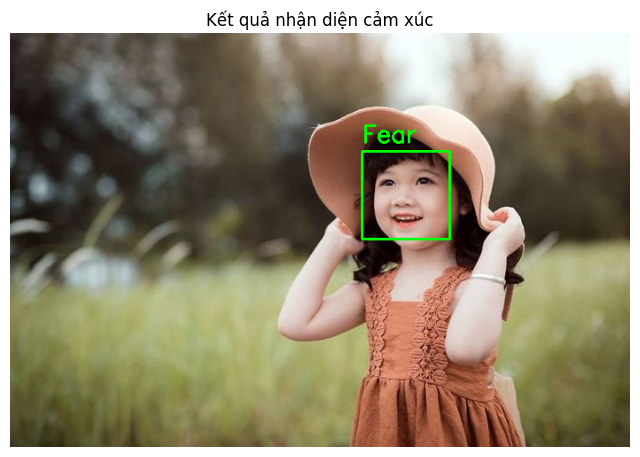

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def demo_image_with_label_matplotlib(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Lỗi: Không đọc được file {img_path}")
        return
    # Đổi ảnh sang RGB để matplotlib hiển thị màu đúng
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    names = ["Anger","Contempt","Disgust","Fear","Happy","Sad","Surprise"]
    face = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    found = False
    for (x, y, w, h) in face.detectMultiScale(gray, 1.3, 5):
        found = True
        roi = cv2.resize(gray[y:y+h, x:x+w], (IMG_SIZE, IMG_SIZE))
        c_in = roi[None, ..., None] / 255.
        bs = sc_s.transform(bow(km_sift, rsift(roi)).reshape(1, -1))
        bd = sc_d.transform(bow(km_dsift, dsift(roi)).reshape(1, -1))
        p = (cnn(c_in, training=False) +
             sift([c_in, bs], training=False) +
             ds([c_in, bd], training=False)) / 3
        label = names[int(np.argmax(p))]
        print(f"Khuôn mặt tại ({x},{y},{w},{h}) → Nhãn dự đoán: {label}")
        # Vẽ lên ảnh RGB để matplotlib hiện đúng màu
        cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(img_rgb, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, .9, (0, 255, 0), 2)
    if not found:
        print("Không phát hiện khuôn mặt nào trong ảnh.")
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("Kết quả nhận diện cảm xúc")
    plt.show()

# Gọi demo:
demo_image_with_label_matplotlib("media/1.jpg")
